# Zadanie 4: Użycie algorytmu Grovera do problemu znajdowania zbioru dominującego

**Gratulujemy dotrwania do finałowego zadania!**
Ostatnie zadanie jest zadaniem konkursowym, czyli koszt obwodu który stworzycie będzie miał bezpośredni wpływ na waszą pozycję w rankingu. Z tego powodu pomoc organizatorów zostanie ograniczona do minimum, głównie do rozwiązywania prostych problemów związanych z oprogramowaniem Qiskit, Pythonem bądź precyzowania reguł zadań.

Powodzenia w rozwiązaniu poniższego zadania!

# Zbiór dominujący

W poprzednim zadaniu implementowaliśmy algorytm Grovera do znajdowania optymalnego rozwiązania problemu Max-Cut. Innymi słowy, szukaliśmy takiego kolorowania, dla którego liczba krawędzi łączących wierzchołki pokolorowane na dwa różne kolory była możliwie duża.

Szukanie najmniejszego _zbioru dominującego_ (ang. *dominating set*) również polega na szukaniu kolorowania wierzchołków, jednak cel jest inny. Zbiorem dominującym nazywamy taki podzbiór wierzchołków, że każdy wierzchołek grafu jest w tym podzbiorze lub sąsiaduje z którymś z wierzchołków z tego podzbioru. Poniżej zaprezentowaliśmy kilka zbiorów dominujących (wyróżnionych kolorem czerwonym):

<img src="graphics/task4_good_examples.png" width=800/>

Zauważcie, że każdy wierzchołek jest pokolorowany na czerwono lub sąsiaduje z takim wierzchołkiem. Poniżej zaprezentowaliśmy przykłady kolorowania grafów nie dających zbioru dominującego.

<img src="graphics/task4_bad_examples.png" width=400/>

Wierzchołki wyróżnione niebieskim kwadratem nie są w zbiorze oraz nie sąsiadują z wierzchołkiem ze zbioru.

Problem znajdowania zbioru dominującego o najmniejszej liczbie wierzchołków jest trudnym problemem (wręcz NP-trudnym). Jednocześnie problem ten ma dość ważne zastosowanie w praktyce: wyobraźcie sobie, że wierzchołki grafu są powiązane z pewną lokalizacją w mieście i umieszczamy w nich urządzenia mierzące jakieś lokalne parametry (np. niech będą to stacje meteorologiczne). Chcemy, aby bieżące wyniki były przekazywane bezpośrednio do serwera, jednak zamiast wstawiać silny nadajnik przy każdej stacji (co jest kosztowne), możemy wstawić je jedynie przy pewnych wyróżnionych stacjach i przesyłać informacje z pozostałych stacji do sąsiadujących stacji z silnymi nadajnikami. Oczywiście, im mniejsza liczba silnych nadajników tym mniejszy koszt.

## Zadanie konkursowe

W ramach finałowego zadania należy znaleźć możliwe lokalizacje nadajników dla poniższej mapy stacji meteorologicznych. Pamiętaj, że stacja może przesyłać dane najdalej do nadajnika przy stacji, z którą sąsiaduje.

<img src="graphics/task4.png" width=400/>

Skądinąd wiemy, że wystarczy ustawić dokładnie trzy nadajniki, co więcej, minimum trzy nadajniki są potrzebne do rozwiązania problemu.

**Rozwiązanie musi spełniać szereg reguł**:

* Skonstruowany obwód nie może składać się z więcej niż 26 kubitów.
* Należy użyć algorytmu Grovera, który poznaliście w zadaniu drugim, z trzema iteracjami.
* Wynik pomiaru $1$ oznacza, że wierzchołek należy do zbioru dominującego, a wynik $0$, że nie należy.
* Zastosuj jedynie jeden 9-bitowy klasyczny rejestr `c`, w którym są zapisywane wyniki pomiaru. W tym celu możecie korzystać z wzorca poniżej.
* __Uwaga: można skorzystać z informacji, że szukamy położenia trzech nadajników, jednak jest to jedyna informacja dotycząca rozwiązania, z której można skorzystać__. W szczególności nie można implementować wyroczni poprzez wcześniejsze znalezienie rozwiązania klasycznymi metodami. **Pomocnicze pytania:** Czy algorytm który skonstruowałem/am będzie działał dla dowolnego grafu nieskierowanego, jeśli będę znał/a rozmiar zbioru dominującego (powinno być: **tak**)? Czy korzystam z jakichś nietypowych cech grafu (jest nieregularny, niedwudzielny itp.) (powinno być: **nie**)? Czy korzystam z wiedzy jakie jest rozwiązanie (powinno być: **nie**)? 
* Obwód kwantowy może składać się jedynie z dostępnych w Qiskit bramek kwantowych (`x`, `ccx`, `mct`, `z`, `u3`, etc.) oraz pomiarów. Nie można korzystać z operacji nie będących bramkami, typu `reset`, `c_if`, itp, oraz bramki `unitary`. Jeśli masz wątpliwości co do użytej bramki - zapytaj mentorów.
* Nie można korzystać z optymalizatorów do obwodów kwantowych opartych na uczeniu maszynowych bądź heurystycznych innych niż `transpile` użyty poniżej. W `transpile` poniżej nie można zmieniać argumentów.
* **Jako rozwiązanie należy wysłać plik `zadanie_4.json` wygenerowany przez `create_submission` oraz plik `zadanie_4.ipynb` wraz z odpowiednimi komentarzami opisującymi kroki algorytmu.**

<div class="alert alert-block alert-danger">
Symulowanie kwantowych obwodów na klasycznym komputerze jest dość czasochłonnym zadaniem - znajdowanie stanu kwantowego może zająć od kilkunastu sekund, do kilkunastu minut. Dlatego prosimy o cierpliwe czekanie na wynik obliczeń w przypadku wysyłania ich do symulatora IBM, gdyż umieszczenie kilku obliczeń jednocześnie na serwerze (szczególnie przy wielu użytkownikach) może bardzo szybko przeciążyć serwer.
</div>

**Skorzystaj z poniższego wzorca.**

In [1]:
from qiskit import *
from qiskit.providers.aer import QasmSimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from bnp_challenge_verifier import grade_circuit, verify_solution4, create_submission

from math import pi

**Rozwiązanie**

Ograniczenie dotyczące liczby kubitów dosyć mocno psuje mi plany. Będę musiał użyć tych samych kubitów dodatkowych do kilku
różnych zadań, co oznacza koniecznośc odobliczenia ich, niestety dość kosztowne. 
Wyrocznia musi sprawdzić dwa warunki:
1. Czy dany zbiór jest dominujący
2. Czy dany zbiór jest minimalny (ma moc 3)

Ponieważ istnieją zbiory o mocy 3 które nie są dominujące i zbiory dominujące o mocy większej niż 3 (co łatwo widać, wystarczy wziąć dowolny zbiór dominujący i dodać do niego dodatkowy nadajnik), te warunki nie są ortogonalne, więc ich dodanie do siebie nie jest operacją odwracalną, co oznacza że potrzebujemy do tego dodatkowego kubitu. 

Mamy 3 kroki w konstrukcji obwodu wyroczni:


**A. Sprawdzanie mocy 3**

Moc 3 jest prosta do sprawdzenia, wystarczy skorzystać z uprzednio zaimplementowanego sumatora, a następnie sprawdzić czy liczba jedynek jest mniejsza od 4. Jako że wierzchołków jest 9, potrzebujemy czterech bitów na zapisanie sumy. Następnie wystarczy sprawdzić, czy pierwsze dwa bity (odpowiadające 8 i 4) są zerami - jeżeli tak, wybieramy kolorowania 3,2,1 lub 0 wierzchołków, ale ponieważ kolorowania 2,1 i 0 wierzchołków nie są dominujące, usunie je drugi krok. 



**B. Które wierzchołki są "zdominowane"?**

Będziemy potrzebowali 9 dodatkowych kubitów, które odpowiadają informacji na temat tego czy odpowiednie wierzchołki są "zdominowane" to znaczy albo sąsiadują z pokolorowanym wierzchołkiem lub same są pokolorowane. Dla każdego wierzchołka następnie tworzymy bramkę MCX, gdzie kubitami kontrolnymi są wszystkie oryginalne wierzchołki sąsiadujące z danym oraz on sam. Tak naprawdę jest to bramka OR - aplikujemy negację na wszystkich kubitach, dzięki czemu ostatni kubit zmienia stan tylko jeżeli kontrolne kubity wszystkie są zerami. Następnie negujemy go, dzięki czemu ostatecznie zmienia on stan tylko jeżeli przynajmniej jeden kubit kontrolny nie jest zerem.

Do ustawienia 9 kubitów odpowiadającym temu czy poszczególne wierzchołki są zdominowane będziemy potrzebować bramek MCX. Ponieważ i tak używamy dodatkowych kubitów, możemy zaimplementować te bramki tak jak są opisane w podręczniku Nielsena i Chuanga (fig. 4.10), za pomocą kaskady bramek Toffoli. Dodatkowe kubity muszą być w stanie 0 na początku obliczeń, a po wykonaniu bramki powracają do tego stanu. Jedynym efektem tej operacji jest więc negacja kubitu "celu", i następuje ona wtedy i tylko wtedy kiedy wszystkie kubity kontroli są w stanie 1. 

Do aplikacji tych bramek wykorzystujemy kolejne dodatkowe kubity, ale one są "resetowane" przez odpowiednie bramki, możemy więc z nich skorzystać w kolejnych krokach.

**C. Sprawdzanie dominacji**

Mamy więc 9 dodatkowych kubitów, i chcemy żeby wyrocznia aplikowała odpowiednią fazę tylko wtedy, gdy WSZYSTKIE one są w stanie 1. Ten krok skomplikowany nie jest, ale również można go zoptymalizować. Normalnie użyłbym bramki opisanej w podręczniku Nielsena i Chuanga (fig. 4.10) do zaaplikowania MCX (multiple controlled X), ale ona wymagałaby 8 dodatkowych kubitów - 9+9+8=26, a mamy jeszcze jeden kubit z poprzedniego kroku i będziemy potrzebowali kolejnego kubitu na bramkę AND która sprawdzi że oba warunki są spełnione. Wobec tego użyję bramek MCX z trzema kontrolami żeby zmniejszyć liczbę potrzebnych kubitów. 

Na szczęście korzystanie z bramki z trzema kontrolami nie kosztuje nas dodatkowych bramek CNOT, co opisuję w kolejnej komórce.

**Dodawanie warunków**

Obwody sprawdzające warunki A i C indywidualnie znakują nam jakiś jeden kubit, jeżeli te warunki są spełnione. Na samym końcu obwodu `qc_mark` musimy wykonać więc bramkę AND, która oznakuje kolejny kubit wtedy i tylko wtedy gdy oba te kubity, oznaczone przez poprzednie podobwody, są jedynkami. Ten kubit jest więc w stanie $| 1 \rangle$ tylko wtedy gdy po pierwsze moc zbioru pokolorowanych wierzchołków jest <=3 oraz ten zbiór jest dominujący. Ponieważ zbiór o mocy 0,1,2 nie może być dominujący, w praktyce bramka $X$ jest aplikowana do tego ostatniego kubitu wtedy i tylko wtedy gdy moc zbioru pokolorowanego jest równa 3 i jest on dominujący, czyli jest on zbiorem, którego szukamy!

**Kolejność poszczególnych zadań**

Krok B. musi być wykonany przed krokiem C., ponieważ krok C. zależy od tego że krok B. został wykonany. Co do kroku A., możemy go wykonać kiedy chcemy. 

Ważna uwaga jest taka, że ostatni krok, który wykonujemy, możemy wykonać tylko do połowy, to znaczy nie "odobliczać" kubitów użytych do jego wykonania. Pamiętajmy że tworzymy tutaj obwód `qc_mark`, który znakuje pewien kubit celu. Następnie aplikujemy do niego bramkę Z i odobliczamy jego całość tak czy siak. Oznacza to, że dwa z powyższych kroków będą musiały być odobliczone dwukrotnie, to znaczy każdy podobwód pojawi się 4 razy w obwodzie wyroczni. Ostatni podobwód natomiast będzie obliczony tylko raz i odobliczony tylko raz. 

Oznacza to że kolejność będzie zależała od tego, czy krok A czy krok C wymagają większej liczby bramek. Ten krok, który wymaga większej liczby bramek, zostanie wykonany jako ostatni. Zaimplementuję oba warianty i zobaczę który z nich działa lepiej. 

**Szczegóły sprawdzania mocy >=3**

Wykorzystamy 6 lub 7 dodatkowych kubitów, w zależności od tego czy jest to krok wykonywany jako ostatni lub nie. Pierwsze kroki są takie same. 

Optymalizując to dodawanie, potrzebujemy 5 pełnych sumatorów, 1 półsumatora, oraz jednej bramki NAND (lub jednej bramki Toffoli w drugim wariancie). Poniżej 0-8 to indeksy wierzchołków grafu, 9-14 to kubity dodatkowe, 15 to kubit "target". Pierwszy indeks oznacza "carry out", drugi oznacza sumę. Pełny sumator pozwala nam na dodanie trzech bitów na raz, otrzymując jeden bit wyższego rzędu (carry) i jeden tego samego rzędu.

Wymieniłem funkcję `partial_full_adder` na `alt_partial_full_adder`. Nowy pełny sumator nie naprawia pierwszych dwóch bitów. Nie jest więc poprawnym rozwiązaniem zadania numer 1. Ale tutaj działa, ponieważ obwód odobliczający i tak naprawia wszystko. Ponieważ jednak w tym pełnym sumatorze bit carry in staje się bitem carry out, a to na sumę potrzebujemy nowego bitu, kolejność dodawania jest następująca: 

    1. 0,1,2 -> 2,9
    2. 3,4,5 -> 5,10
    3. 6,7,8 -> 8,11
    4. 9,10,11 -> 11,12
    5. 2,5,8 -> 8,13
    6. 11,13 -> 14,13 (półsumator)

    Na końcu bity o wadze 4 to bity 8 i 14, więc dalej postępujemy podobnie jak w poprzednim rozwiązaniu.

Z poprzedniego kroku będziemy mieli wartość na kubicie 15, która będzie odpowiadała temu czy dane kolorowanie generuje zbiór dominujący. Z powodu braku dodatkowych kubitów (jest ich od 0 do 16), wykonujemy bramkę z trzema kontrolami (13,14,15) rzucając wynik na kubit 16. Oczywiście 13 i 14 są wcześniej zanegowane. 



**Wyrocznia**

Wyrocznia implementowana jest tak, jak opisane w opisie zadania 2, tj. (kopiuję to po prostu):
    
"implementujemy obwód, który na ustalonym kubicie aplikuje $X$ tylko dla niektórych stanów bazowych z rozwiązania. Następnie aplikujemy na tym kubice bramkę $Z$ (która zmienia znak dla $|1\rangle$, czyli dla interesujących nas rozwiązań). Potem następuje odwrócenie całej operacji, aby przenieść tę zmianę fazy z powrotem do początkowych kubitów. Innymi słowy, jeśli obwód `qc_mark` będzie aplikował bramkę $X$ na kubicie z rejestru `qreg_marked`, to schemat będzie wyglądał następująco:
```
qreg_grover = QuantumRegister(n)
creg_grover = ClassicalRegister(n)
qreg_ancilla = QuantumRegister(m)
qreg_marked = QuantumRegister(1)

circuit = QuantumCircuit(qreg_grover, qreg_ancilla, qreg_marked, creg_grover)

# stosujemy operator Hadamarda
circuit.h(grover_reg)

for _ in range(int(math.pi/4*math.sqrt(2**n/4))):
    circuit.compose(qc_mark)
    circuit.z(qreg_marked) 
    circuit.compose(qc_mark.inverse()) # odobliczanie
    
    inversion_about_average(circuit, grover_reg)
```
"


**Komentarz na temat lustrzanych bramek CCX oraz CCCX**

Spójrzmy na bardzo prosty obwód:

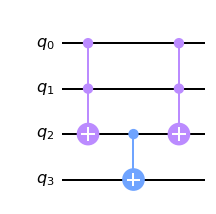

In [2]:
qc = QuantumCircuit(4)

qc.ccx(0,1,2)

qc.cx(2,3)

qc.ccx(0,1,2)

qc.draw('mpl')

Zauważmy, że górne dwa kubity funkcjonują tylko jako kubity kontrolne. Między dwoma bramkami Toffoli, z ich perspektywy nic się nie dzieje. Zobaczmy co dzieje się, jeżeli użyjemy funkcji transpile na tym obwodzie.

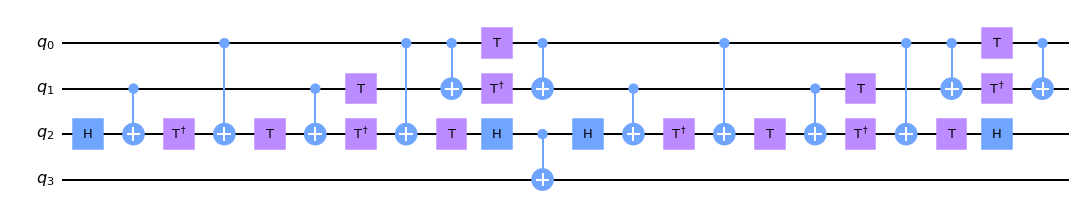

In [3]:
qct = transpile(qc,basis_gates=['cx', 'h', 't', 'tdg'], optimization_level=3) #basis gates chosen for display purposes
qct.draw('mpl')

Zauważmy że ostatnie dwie bramki CNOT oraz trzy bramki T, które budują bramkę Toffoli, działają tylko na dwa górne kubity. Zauważmy również, że ponieważ bramka Toffoli jest swoją własną odwrotnością, transpilowany obwód który ją implementuje musi być swoją własną odwrotnością. Zobaczmy co dzieje się, jeżeli odwrócimy ten obwód ręcznie.

<ipython-input-4-99da70c7b56e>:12: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qcbuild = qcbuild + qctoff #replace with the compose() method when it starts working again
C:\Users\cazol\Anaconda3\envs\bnpparibas\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


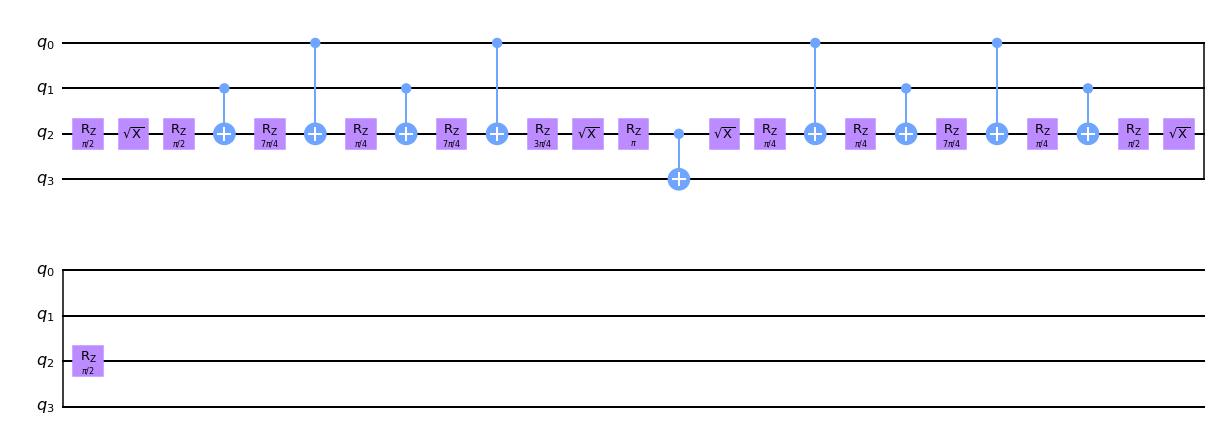

In [4]:
#Now let's try

#make a circuit that just applies a Toffoli gate
qctoff = QuantumCircuit(4) 
qctoff.ccx(0,1,2)

#transpile
qctoff = transpile(qctoff,basis_gates=['cx','t','tdg','h'])

#build the "same" circuit as before and use the fact Toffoli is its own inverse
qcbuild = QuantumCircuit(4)
qcbuild = qcbuild + qctoff #replace with the compose() method when it starts working again
qcbuild.cx(2,3)
qcbuild = qcbuild + qctoff.inverse() #replace with the compose() method when it starts working again

#transpile it again to cancel things
qcbuild = transpile(qcbuild,basis_gates=['cx', 'rz','sx'], optimization_level=3)

qcbuild.draw('mpl')

Bramki aplikowane do dwóch górnych kubitów skracają się w tej wersji. Dwie bramki Toffoli wymagają więc nie 12, a jedynie 8 CNOTów i nie 14, a jedynie 8 bramek T. 

**Ponieważ zadanie wprost mówi, że zabronione jest korzystanie z optymalizatorów lub zmienianie argumentów funkcji transpile, zdecydowałem się przepisać te bramki oraz ich odwrotności ręcznie.**

Powyższe transpilacje nie stanowią części rozwiązania, są jedynie poglądowe. 

Innymi słowy, transpiler Qiskita nie sprawdza, czy odwrotność bramki Toffoli daje bardziej optymalny obwód, więc muszę go do tego zmusić ręcznie. Odwrotność bramki Toffoli to po prostu bramka Toffoli, więc oczywiście można jednej i drugiej używać zamiennie.

Stworzyłem osobne funkcje, które odpowiadają za "częściowe" wykonanie bramki Toffoli w jedną lub drugą stronę. Odpowiadają wszystkim operacjom, które oddziałują z ostatnim, negowanym kubitem, a pomijają bramki, które nie wchodzą z nim w interakcję. Jeżeli zaaplikujemy `partial_toffoli()` do indeksów a,b,c, następnie nie wykonamy żadnych operacji na kubitach a,b, a potem zaaplikujemy `partial_toffoli_inv()`, to efekt będzie dokładnie taki sam, jak gdybyśmy zaaplikowali pełną bramkę Toffoli, zrobili coś z kubitem c, po czym zaaplikowali bramkę Toffoli do a,b,c po raz kolejny. 

Dokładnie ten sam efekt występuje przy bramce CCCX (potrójnie kontrolowany NOT). Również stworzyłem odpowiednie funkcje które nie wymagają korzystania z transpilera. 

Zgłosiłem również feature request do Qiskit terra który tego dotyczy: https://github.com/Qiskit/qiskit-terra/issues/6740 . Bez was bym tego nie znalazł, także dzięki! 

Zauważmy, że zaaplikowanie dwóch par bramek Toffoli to w sumie 16 CNOTów. Zaaplikowanie jednej pary bramki CCCX to również 16 CNOTów. Okazuje się, tak jak pisałem wyżej, że konieczność zaoszczędzenia kubitu w kroku C. nie sprawia że musimy wykorzystać więcej CNOTów. 

**Więcej o fazach w bramkach CCX i CCCX, których używam w obwodzie znakującym**

Poniższe rozważania dotyczą jedynie obwodu znakującego, tj. `qc_mark`, który stanowi część obwodu wyroczni.

Zauważmy, że obie bramki CCX oraz CCCX zaczynają i kończą się Hadamardem na kubicie celu. Jeżeli wyrzucimy tego Hadamarda, obie te bramki stają się diagonalnymi bramkami unitarnymi. Możemy traktować je tak jak opisane w pracach [1] oraz [2]. 

Zauważmy, że te bramki składają się z ciągu operatorów Walsha, które aplikują odpowiednie rotacje fazowe na ostatnim kubicie, a następnie z ciągu operatorów Walsha, które aplikują rotacje fazowe na pozostałych kubitach. Jeżeli wyeliminujemy te ostatnie (to te same które skracają się w moim powyższym opisie), to nasza bramka poprawnie zamienia miejscami stany $|1111\rangle$ i $|1110\rangle$, ale poza tym aplikuje fazy na pozostałych stanach, fazy te jednak nie zależą już od stanu ostatniego kubitu. Oznacza to w skrócie że fazy na kubitach kontrolnych są nieprawidłowe. 

Każdy operator Walsha jest postaci $ \exp \left(-i a_k \left( Z_1^{b_1} \otimes Z_2^{b_2} \otimes \dots \otimes Z_n^{b_n}\right)\right)$, gdzie zmienne $b_1, b_2, \dots, b_n$ przyjmują wartości $0,1$. Oznacza to, że każdy operator Walsha po prostu aplikuje jakąś rotację względem operatora będącego iloczynem tensorowym operatorów $Z$ Pauliego. 

Oczywiście eliminacja tych rotacji pomaga zmniejszyć rozmiar obwodu. Pytanie tylko, czy cokolwiek psuje? 

W skrócie zależy to od tego, co dzieje się na kubitach, których faza jest nieprawidłowa. Na szczęście, jedyne co ja chcę z nimi robić to 
* Aplikowanie innych bramek fazowych (Z-rotacji)
* Korzystanie z nich jako kontroli do bramek CX
* Okazjonalnie użycie jako targetu bramki CCX lub CCCX

Zauważmy że zła faza nie przeszkadza nam w wykonaniu żadnego z tych zadań. Aplikowanie innych bramek fazowych jest najprostsze do uzasadnienia - one po prostu komutują z operatorami Walsha, ponieważ operatory $Z$ Pauliego komutują ze sobą nawzajem. Kontrole również komutują z kontrolami i bramkami fazowymi.

Co do użycia tych bitów jako targetów, de facto oznacza to użycie na nich bramki $X$ Pauliego. Tutaj komutacji nie ma, ale na szczęście jest antykomutacja - to znaczy komutacja następuje z pojawieniem się czynnika (-1) przy wartości fazy: 

$$ \exp \left(-i a_k \left( Z_1^{b_1} \otimes Z_2^{b_2} \otimes \dots \otimes Z_n^{b_n}\right)\right) X_j = X_j \exp \left( -(-1)^{b_j} i a_k \left( Z_1^{b_1} \otimes Z_2^{b_2} \otimes \dots \otimes Z_n^{b_n}\right) \right)$$

(tj. faza dostaje minus jeżeli operator $Z$ odpowiadający temu samemu kubitowi co operator $X$ występuje w iloczynie).
W praktyce w moim obwodzie na kubitach ancilli, które zaczynają w stanie $|0 \rangle$, bramki $X$ aplikowane są parami, to znaczy każda bramka $CX$ aplikowana na takim kubicie, która zmienia jego stan z $|0 \rangle$ na $|1 \rangle$ z sukcesem (to znaczy kiedy wszystkie kubity kontrolne są OK), następnie zostaje zaaplikowana po raz kolejny z tymi samymi kontrolami, i zmienia stan z powrotem z $|1 \rangle$ na $|0 \rangle$. W praktyce oznacza to, że $X_j$ komutuje "dwa razy" przez te wszystkie operatory Walsha i dwukrotnie zmienia znak przy fazie - czyli ostatecznie nawet faza się nie zmienia. 

Oczywiście pierwszą rzeczą jaką robimy po obwodzie wyroczni jest aplikacja warstwy Hadamardów. Jakiekolwiek niepoprawne fazy tam to śmierć naszego algorytmu - Hadamard jest wrażliwy na fazę, w końcu stany $|+ \rangle$ i $|- \rangle$ różnią się tylko fazą! Na szczęście, jak opisane wyżej, złe fazy zostaną odobliczone w obwodzie wyroczni, ponieważ aplikuję odwrotność obwodu `qc_mark` na wszystkich kubitach poza ostatnim targetem. 

**Próba zostawienia niepoprawnych faz w obwodzie operatora dyfuzji kończy się źle - ponieważ nie jest on odobliczany i fazy nie są naprawiane**


[1] Stephen S. Bullock and Igor L. Markov. 2004. Asymptotically optimal circuits for arbitrary n-qubit diagonal comutations. Quantum Info. Comput. 4, 1 (January 2004), 27–47.

[2] Jonathan Welch et al, 2014. Efficient quantum circuits for diagonal unitaries
without ancillas New J. Phys. 16 033040

In [5]:
#będę potrzebował bramki Toffoli. Jest ona swoją własną odwrotnością, ale wersja zaimplementowana w Qiskicie jest niesymetryczna. 
#czasem chcemy bramkę Toffoli odobliczyć częściowo, korzystając z wersji qiskitowej całość kosztuje 12 cnotów, podczas gdy
#implementując odwrotność bezpośrednio spada to do 8 cnotów

def toffoli(qcirc,a,b,c):
    #tej części zawsze potrzebujemy
    qcirc.h(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.h(c)
    
    #ta część powinna skrócić się z odwrotnością
    qcirc.t(b)
    qcirc.cx(a,b)
    qcirc.t(a)
    qcirc.tdg(b)
    qcirc.cx(a,b)


#stwórzmy też częściowe toffoli, które nie zawiera ostatnich 5 operacji, oraz jej odwrotność

def partial_toffoli(qcirc,a,b,c):
    qcirc.h(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.h(c)
    
#do odwrotności idziemy od końca, odwrotnością Hadamarda jest Hadamard, CNOT-a - CNOT, a bramki T bramka Tdg i vice versa
    
def partial_toffoli_inv(qcirc,a,b,c):
    qcirc.h(c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.cx(b,c)
    qcirc.h(c)

In [6]:
#Zróbmy dokładnie to samo dla potrójnej bramki

def cccx_gate(qcirc,a,b,c,d):
    qcirc.h(d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.h(d)
    
    #bez ostatniego kubitu:
    qcirc.cx(a,c)
    qcirc.rz(1/8*pi,c)
    qcirc.cx(b,c)
    qcirc.rz(15/8*pi,c)
    qcirc.cx(a,c)
    qcirc.rz(1/8*pi,c)
    qcirc.cx(b,c)
    qcirc.rz(15/8*pi,c)
    
    #bez dwóch ostatnich kubitów
    qcirc.cx(a,b)
    qcirc.rz(1/8*pi,b)
    qcirc.cx(a,b)
    qcirc.rz(15/8*pi,b)
    qcirc.rz(15/8*pi,a)
    
def halfpartial_cccx_gate(qcirc,a,b,c,d):
    qcirc.h(d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.h(d)
    
    #bez ostatniego kubitu:
    qcirc.cx(a,c)
    qcirc.rz(1/8*pi,c)
    qcirc.cx(b,c)
    qcirc.rz(15/8*pi,c)
    qcirc.cx(a,c)
    qcirc.rz(1/8*pi,c)
    qcirc.cx(b,c)
    qcirc.rz(15/8*pi,c)
    
def partial_cccx_gate(qcirc,a,b,c,d):
    qcirc.h(d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.h(d)
    
def partial_cccx_gate_inv(qcirc,a,b,c,d):
    qcirc.h(d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(a,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(b,d)
    qcirc.rz(1/8*pi,d)
    qcirc.cx(c,d)
    qcirc.rz(15/8*pi,d)
    qcirc.cx(a,d)
    qcirc.h(d)

In [7]:
def half_adder(qcirc,a,b,c):
    #half adder to bramka toffoli bez ostatniego CNOTa
    qcirc.h(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.cx(b,c)
    qcirc.tdg(c)
    qcirc.cx(a,c)
    qcirc.t(c)
    qcirc.h(c)
    
    qcirc.t(b)
    qcirc.cx(a,b)
    qcirc.t(a)
    qcirc.tdg(b)

In [8]:
def full_adder(qcirc,a,b,c,d):
    ''' a,b to dodawane bity, c to carry -> suma, d to nowe carry'''
    
    
    half_adder(qcirc,a,b,d)

    half_adder(qcirc,b,c,d)
    
    qcirc.cx(a,b)

In [9]:
def partial_full_adder(qcirc,a,b,c,d):
    ''' a,b to dodawane bity, c to carry -> suma, d to nowe carry
    do skorzystania kiedy nic nie dzieje się na bitach a,b przed zaaplikowaniem odwrotności'''
    
    
    half_adder(qcirc,a,b,d)

    half_adder(qcirc,b,c,d)

In [10]:
def alt_partial_full_adder(qcirc,a,b,c,d):
    '''
    alternatywny pełny sumator, który nie naprawia kubitów a i b
    a,b to dodawane bity, c to carry in -> carry out, d to suma
    inaczej niż wcześniej! 
    '''
    
    qcirc.cx(c,a)
    qcirc.cx(a,d)
    qcirc.cx(b,d)
    qcirc.cx(c,b)
    partial_toffoli(qcirc,a,b,c)
    

**Wyjaśnienie alternatywnego pełnego sumatora:**

Bit carry-out jest 1 wiw gdy dwa lub trzy z trzech dodawanych bitów są 1. Zauważmy że jeżeli zamienimy stany $|110 \rangle$ i $|001\rangle$, pozostawiając pozostałe bez zmian (to jest aplikujemy macierz unitarną, która jest macierzą permutacji zamieniającą te dwa stany miejscami), to ten warunek zamienia się na ostatni bit będący 1. Więc po prostu bierzemy ten bit jako nowe carry-out i idziemy dalej. 

Taka macierz permutacji to po prostu bramka Toffoli postawiona trochę na głowie (po to są cx(c,a) oraz cx(c,b)). Normalnie należałoby potem "naprawić" dwa pierwsze bity, ale tutaj nie robimy tego, bo z tymi bitami nic się nie dzieje do momentu kiedy aplikujemy .inverse() aby odobliczyć tą część obwodu w ramach wyroczni. 

Dwie bramki cx(a,d), cx(b,d) to po prostu XOR na trzech bitach, jako że po pierwszym CX bit a już jest XORem oryginalnych bitów a oraz c.

In [11]:
def nc_mcx(qcirc,controls,ancillae,target):
    """implementuje bramkę MCX bazowaną na fig. 4.10 z Nielsena i Chuanga
    Jeżeli kubitów kontrolnych jest n, potrzebuje dodatkowych n-2 kubitów
    po wszystkim kubity dodatkowe wracają do stanu początkowego (0),
    a kubit target jest zanegowany
    controls - lista n >= 3 indeksów kubitów kontrolnych
    ancillae - lista n-2 indeksów kubitów dodatkowych
    target - indeks kubitu docelowego"""
    
    n = len(controls)
    
    partial_toffoli(qcirc,controls[0],controls[1],ancillae[0])
    #toffoli(qcirc,controls[0],controls[1],ancillae[0])
    
    for i in range(n-3):
        partial_toffoli(qcirc,controls[i+2],ancillae[i],ancillae[i+1])
        #toffoli(qcirc,controls[i+2],ancillae[i],ancillae[i+1])

    toffoli(qcirc,controls[-1],ancillae[-1],target)
    
    #odwracamy, to samo co w poprzedniej pętli ale w drugą stronę:
    
    for i in range(n-3):
        partial_toffoli_inv(qcirc,controls[(n-2-i)],ancillae[(n-4-i)],ancillae[(n-3-i)])
        #toffoli(qcirc,controls[(n-2-i)],ancillae[(n-4-i)],ancillae[(n-3-i)])
    
    partial_toffoli_inv(qcirc,controls[0],controls[1],ancillae[0])
    #toffoli(qcirc,controls[0],controls[1],ancillae[0])

Stworzyłem osobne funkcje `nc_m4x()`,`nc_m5x()`, `nc_m6x()`, `nc_m7x()`, `nc_m8x()`, `nc_m9x()` które tworzą multiply controlled gate na 4,5,6,7,8,9 kubitach kontrolnych konkretnie, troszeczkę bardziej optymalnie niż wersja ogólna.

In [12]:
def nc_c4x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 4 kubity kontrolne"""
    
    partial_toffoli(qcirc,controls[0],controls[1],ancillae[0])
    partial_toffoli(qcirc,controls[2],controls[3],ancillae[1])
    
    #nie naprawiam faz
    partial_toffoli(qcirc,ancillae[0],ancillae[1],target)
    
    partial_toffoli_inv(qcirc,controls[2],controls[3],controls[4],ancillae[1])
    partial_toffoli_inv(qcirc,controls[0],controls[1],ancillae[0])

In [13]:
def nc_c5x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 5 kubitów kontrolnych"""
    
    partial_toffoli(qcirc,controls[0],controls[1],ancillae[0])
    partial_cccx_gate(qcirc,controls[2],controls[3],controls[4],ancillae[1])
    
    #nie naprawiam faz
    partial_toffoli(qcirc,ancillae[0],ancillae[1],target)
    
    partial_cccx_gate_inv(qcirc,controls[2],controls[3],controls[4],ancillae[1])
    partial_toffoli_inv(qcirc,controls[0],controls[1],ancillae[0])


In [14]:
def nc_c5x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 5 kubitów kontrolnych"""
    
    partial_cccx_gate(qcirc,controls[0],controls[1],controls[2],ancillae[0])
    
    #nie naprawiam faz
    partial_cccx_gate(qcirc,controls[3],controls[4],ancillae[0],target)
    
    partial_cccx_gate_inv(qcirc,controls[0],controls[1],controls[2],ancillae[0])


In [15]:
def nc_c6x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 6 kubitów kontrolnych"""
    
    partial_cccx_gate(qcirc,controls[0],controls[1],controls[2],ancillae[0])
    partial_cccx_gate(qcirc,controls[3],controls[4],controls[5],ancillae[1])
    
    #nie naprawiam faz
    partial_toffoli(qcirc,ancillae[0],ancillae[1],target)
    
    partial_cccx_gate_inv(qcirc,controls[3],controls[4],controls[5],ancillae[1])
    partial_cccx_gate_inv(qcirc,controls[0],controls[1],controls[2],ancillae[0])

In [16]:
def nc_c7x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 7 kubitów kontrolnych"""
    
    partial_toffoli(qcirc,controls[0],controls[1],ancillae[0])
    partial_cccx_gate(qcirc,controls[2],controls[3],controls[4],ancillae[1])
    partial_toffoli(qcirc,controls[5],controls[6],ancillae[2])
    
    #nie naprawiam faz
    partial_cccx_gate(qcirc,ancillae[0],ancillae[1], ancillae[3],target)
    
    partial_toffoli_inv(qcirc,controls[5],controls[6],ancillae[2])
    partial_cccx_gate_inv(qcirc,controls[2],controls[3],controls[4],ancillae[1])
    partial_toffoli_inv(qcirc,controls[0],controls[1],ancillae[0])

In [17]:
def nc_c8x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 8 kubitów kontrolnych i 3 ancille"""
    
    partial_cccx_gate(qcirc,controls[0],controls[1],controls[2],ancillae[0])
    partial_cccx_gate(qcirc,controls[3],controls[4],controls[5],ancillae[1])
    partial_toffoli(qcirc,controls[6],controls[7],ancillae[2])
    
    #tu naprawiam fazę, bo z tego korzystam w obwodzie operatora dyfuzji.
    #mógłbym wprowadzić zmienną bool która decyduje czy faza jest naprawiana czy nie ale już mi się nie chce
    cccx_gate(qcirc,ancillae[0], ancillae[1], ancillae[2], target)

    partial_toffoli_inv(qcirc,controls[6],controls[7],ancillae[2])
    partial_cccx_gate_inv(qcirc,controls[3],controls[4],controls[5],ancillae[1])
    partial_cccx_gate_inv(qcirc,controls[0],controls[1],controls[2],ancillae[0])


In [18]:
def nc_c9x(qcirc,controls,ancillae,target):
    """zoptymizowana bramka na konkretnie 9 kubitów kontrolnych i 3 ancille"""
    
    partial_cccx_gate(qcirc,controls[0],controls[1],controls[2],ancillae[0])
    partial_cccx_gate(qcirc,controls[3],controls[4],controls[5],ancillae[1])
    partial_cccx_gate(qcirc,controls[6],controls[7],controls[8],ancillae[2])
    
    #nie naprawiam faz
    partial_cccx_gate(qcirc,ancillae[0], ancillae[1], ancillae[2], target)

    partial_cccx_gate_inv(qcirc,controls[6],controls[7],controls[8],ancillae[2])
    partial_cccx_gate_inv(qcirc,controls[3],controls[4],controls[5],ancillae[1])
    partial_cccx_gate_inv(qcirc,controls[0],controls[1],controls[2],ancillae[0])

**Bramki MCX korzystające z ancilli**

Działają one jak proste obwody logiczne. Zamiast wykonywać jedną operację, która aplikuje $X$ na ostatnim kubicie wtedy i tylko wtedy, gdy stan kubitów kontrolnych jest $| 1 \rangle$, zamiast tego operujemy kaskadowo. Wszystkie dodatkowe kubity są inicjowane w stanie $| 0 \rangle$ (z ewentualną jakąś fazą, patrz wyżej).  Najpierw aplikujemy bramkę AND (Toffoli) na kubitach 0 i 1, rzucając wynik na pierwszy kubit dodatkowy. Jeżeli kubity 0 i 1 były w stanie $| 1 \rangle$, to ancilla również zmienia się na $| 1 \rangle$. Następnie te ancille stają się kontrolami kolejnych operacji. Finalnie, ostatni kubit "target" dostaje bramkę $X$ wtedy i tylko wtedy kiedy wszystkie oryginalne kubity kontrolne były w stanie $| 1 \rangle$. Kubity ancilli należy potem odobliczyć do stanu $| 0 \rangle$ (z ewentualną jakąś fazą, może być inna), żeby można ich było użyć później. 

Tak jak pisałem wyżej, zamiast "pełnych" bramek CCX i CCCX tam gdzie to możliwe używam bramek fazowych, które poprawnie zmieniają stan targetu, ale mieszają fazy na kubitach kontrolnych. Są to funkcje `partial_toffoli()` oraz `partial_cccx_gate()`.

W celu wizualizacji jak w zasadzie wyglądają te bramki można w powyższych definicjach pozmieniać te funkcje na metody `.ccx()` oraz `.mcx()` (definiując trzy kubity control) odpowiednio, wtedy obwod narysuje się z ładnymi fioletowymi bramkami kontrolnymi.

**Kod właściwego rozwiązania**

Aby upewnić sprawdzających, że nie korzystam z żadnych własności danego grafu (poza liczbą wierzchołków), postarałem się żeby kolejna komórka była jak najbardziej czytelna. 

Graf implementowany jest jako słownik, gdzie każdemu wierzchołkowi odpowiada lista wierzchołków w odległości 1 lub 0 od niego. To znaczy lista jego sąsiadów oraz on sam. Inny graf (jeżeli jest większy może wymagać dodatkowych kubitów), jeżeli zostanie zapisany dokładnie tak samo, powinien działać z dalszą częścią tego rozwiązania. To znaczy, jeżeli taki graf ma akurat najmniejszy zbiór dominujący o mocy 3, mój algorytm wszystkie te zbiory znajdzie. 

Jeżeli ten inny graf ma więcej lub mniej niż 9 wierzchołków to oczywiście nie będzie działał wprost z poniższym rozwiązaniem, ale pomysł działa nadal, trzeba tylko zmodyfikować szczegóły. Ale inne połączenia powinny działać tak samo. 

In [19]:
#KROK B. opisany wyżej

qgrover = QuantumRegister(9, 'grover')
cgrover = ClassicalRegister(9,'cgrover')
ancilla = QuantumRegister(17,'ancilla') #wykorzystamy wszystko 9+17=26

qc_dom = QuantumCircuit(qgrover,ancilla,cgrover) #obwód tworzący oznaczenie dominacji na 9 dodatkowych kubitach

#definiujemy graf za pomocą przypisania każdemu wierzchołkowi listy jego sąsiadów + jego samego

g = {}
g[0] = [0,1,6]
g[1] = [0,1,7]
g[2] = [2,3,7]
g[3] = [2,3,8]
g[4] = [4,5,8]
g[5] = [4,5,6]
g[6] = [0,5,6,7,8]
g[7] = [1,2,6,7,8]
g[8] = [3,4,6,7,8]

n = 9 #liczba wierzchołków

#dla każdego wierzchołka aplikujemy bramkę OR

for i in g.keys():
    
    k = len(g[i])
    
    #negacja wszystkich kubitów
    for j in g[i]:
        qc_dom.x(j)
    
    #negacja celu
    qc_dom.x(i+n)
    
    #dla formalności żeby pokazać jak rozwiązanie działa dla innych grafów. k=rząd +1, 
    #więc k=2 - liść, k=1 - niepołączony z niczym wierzchołek
    #w przypadku k=2 wystarczy jedna bramka OR,
    #w przypadku k=1 wierzchołek jest zdominowany tylko jeżeli jest sam pokolorowany
    
    if k==1:
        qc_dom.cx(i,i+n)
        
    elif k==2: 
        toffoli(qc_dom,g[i][0],g[i][1],i+n)
    
    elif k==3: 
        partial_cccx_gate(qc_dom,g[i][0],g[i][1],g[i][2],i+n)
        
    elif k==4:
        anc_ind = [2*n,2*n+1]
        nc_c4x(qc_dom,g[i],anc_ind,i+n)
        
    elif k==5:
        anc_ind = [2*n,2*n+1]
        nc_c5x(qc_dom,g[i],anc_ind,i+n)
   
    elif k==6:
        anc_ind = [2*n,2*n+1]
        nc_c6x(qc_dom,g[i],anc_ind,i+n)
        
    elif k==7:
        anc_ind = [2*n,2*n+1,2*n+2]
        nc_c7x(qc_dom,g[i],anc_ind,i+n)
        
    #jeżeli k>=8 dla dowolnego wierzchołka to graf nie spełnia warunków zadania, bo najmniejszy zbiór dominujący ma moc 2 lub 1,
    #co widać prosto, wystarczy pokolorować ten wierzchołek, musi on być połączony z 7 innymi, czyli zostaje max jeden 
    #niezdominowany.
    
    #tym niemniej, ta metoda może być z łatwością rozpisana na inne grafy, wszystkie te bramki robią dokładnie to samo, jedynie
    #dla różnej liczby kubitów
    
    #odwrócenie negacji
    for j in g[i]:
        qc_dom.x(j)

#zbiór pokolorowanych wierzchołków jest dominujący jeżeli kubity od ancilla[0] do ancilla[8] są wszystkie w stanie 1

In [20]:
#KROK C opisany wyżej - wersja jeżeli NIE JEST to ostatni krok w obwodzie wyroczni

qc_check_dom_unc = QuantumCircuit(qgrover,ancilla,cgrover)  

#bramka mcx na 9 kubitach kontrolnych - moja domowa funkcja nienaprawiająca faz
nc_c9x(qc_check_dom_unc,ancilla[0:9],ancilla[9:12],ancilla[15])

#jeżeli kolorowanie jest dominujące, ancilla[15] przechowuje informację o tym, że tak właśnie jest 

In [21]:
#KROK A opisany wyżej - wersja jeżeli JEST to ostatni krok w obwodzie wyroczni
#z użyciem alternatywnego pełnego sumatora

#oczywiście, jeżeli najmniejszy zbiór dominujący ma moc inną niż 3, poniższy kod należy zmodyfikować
#idea rozwiązania jednak nie ulega zmianie, ta część jest niezależna od reszty
#jest to po prostu jakiś sumator, który dodaje bity na rejestrach qgrover i aplikuje bramkę X na pewnym targecie
#jeżeli suma ta spełnia pewien warunek. tutaj ten warunek to bycie <=3, dlaczego nie ==3 opisałem w części wstępnej

qc_check_sum_alt2 = QuantumCircuit(qgrover,ancilla,cgrover) #obwód sprawdzający moc zbioru 

#sprawdzamy moc zbioru <= 3

alt_partial_full_adder(qc_check_sum_alt2,0,1,2,ancilla[9])
alt_partial_full_adder(qc_check_sum_alt2,3,4,5,ancilla[10])
alt_partial_full_adder(qc_check_sum_alt2,6,7,8,ancilla[11])
alt_partial_full_adder(qc_check_sum_alt2,ancilla[9],ancilla[10],ancilla[11],ancilla[12])

alt_partial_full_adder(qc_check_sum_alt2,2,5,8,ancilla[13])
half_adder(qc_check_sum_alt2,ancilla[11],ancilla[13],ancilla[14])

#rejestry qgrover[8] oraz ancilla[14] zawierają bity o wadze 4. jeżeli którykolwiek z nich jest 1, to suma 
#wszystkitch bitów jest większa niż 3. negujemy je oba, żeby bramka CCCX na dole zadziałała tylko
#jeżeli oba oryginalnie są zerami

qc_check_sum_alt2.x(8)
qc_check_sum_alt2.x(ancilla[14])

#w tej wersji to jest ostatnia rzecz, którą robimy, wobec czego nie musimy odobliczać, zrobimy to i tak w obwodzie wyroczni
#bierzemy pod uwagę że ancilla[15] zawiera informację o tym czy zbiór jest dominujący, jeżeli KROK C został wykonany wcześniej

partial_cccx_gate(qc_check_sum_alt2,8,ancilla[14],ancilla[15], ancilla[16])

#po tym obwodzie ancilla[16] jest w stanie 1 wiw gdy moc zbioru wynosi 0,1,2 lub 3 ORAZ ancilla[15]=1 z jakiegoś powodu

In [22]:
qc_check_sum_alt2.count_ops()['cx']

53

In [23]:
qc_dom.count_ops()['cx']

120

In [24]:
qc_check_dom_unc.count_ops()['cx']

56

In [25]:
#konstruujemy pełny obwód znakujący ostatni kubit, jeżeli wszystko sppełnia warunki zadania (A,B,C)
#Wersja kolejności kroków B->C->A

qc_mark = QuantumCircuit(qgrover,ancilla,cgrover)

#tworzymy oznaczenie dominacji

qc_mark = qc_mark + qc_dom

#sprawdzamy dominację

qc_mark = qc_mark + qc_check_dom_unc

#sprawdzamy moc zbioru pokolorowanego <=3

qc_mark = qc_mark + qc_check_sum_alt2


In [26]:
#pełna wyrocznia

qc_oracle = QuantumCircuit(qgrover,ancilla,cgrover) 

qc_oracle = qc_oracle + qc_mark
qc_oracle.z(ancilla[16])
qc_oracle = qc_oracle + qc_mark.inverse()

#wszystko powinno być już i tak w bramkach CX i pojedynczych 

In [27]:
qc_oracle.count_ops()

OrderedDict([('cx', 458),
             ('rz', 368),
             ('x', 154),
             ('h', 116),
             ('tdg', 27),
             ('t', 27),
             ('z', 1)])

**Inna kolejność jest możliwa!**

Po pierwsze, kolejność ma znaczenie tylko dlatego, że liczba kubitów jest ograniczona. Gdybym mógł wykorzystać o wiele wiele więcej kubitów dodatkowych, nie trzeba by było ich czyścić, użyłbym po prostu innych kubitów w każdym kroku A, B i C i wyczyścił je wszystkie "za jednym zamachem" w procesie odobliczania podczas konstruowania wyroczni. 

Zauważmy, że w kroku C czyszczę kubity ancilli po sprawdzeniu czy zbiór jest zdominowany. Robię to, ponieważ potrzebuję ich potem w kroku A. W kroku A natomiast już nic nie czyszczę, bo korzystam z alternatywnego pełnego sumatora który generalnie psuje bardzo dużo. Ten krok jest natomiast ostatnią częścią `qc_mark` i dlatego zostaje szybciutko odobliczony w obwodzie `qc_oracle`. 

Możliwe jest że dla innego grafu zrobienie kroku A jako pierwszego ma więcej sensu. Nie wiem! Zamieniłem je miejscami jakoś w okolicach wtorku i potem optymalizowałem tylko jedną kolejność. Jestem przekonany że ta kolejność jest lepsza dla tego grafu. 

Do stworzenia operatora dyfuzji również używam bramek MCX (prawie) takich jak opisane w podręczniku Nielsena i Chuanga. Potrzeba na to o wiele mniej CNOTów za cenę dodatkowych kubitów, ale skoro i tak już ich używamy to implementacji wyroczni, to nic nie szkodzi.

In [28]:
qc_dif = QuantumCircuit(qgrover,ancilla,cgrover)

qc_dif.h(qgrover)
qc_dif.x(qgrover)

qc_dif.h(qgrover[-1])

#wpisałem to ręcznie bo coś nie działało ale wiadomo o co chodzi

nc_c8x(qc_dif, [0,1,2,3,4,5,6,7],[22,21,20],8)

qc_dif.h(qgrover[-1])
qc_dif.x(qgrover)
qc_dif.h(qgrover)

In [29]:
from qiskit import *
from qiskit.providers.aer import QasmSimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from bnp_challenge_verifier import grade_circuit, verify_solution4, create_submission
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_) 

#qgrover = QuantumRegister(9)
#cgrover = ClassicalRegister(9)
qcirc = QuantumCircuit(qgrover, cgrover,ancilla) # możesz oczywiście dodać inne rejestry kwantowe

qcirc.h(qgrover)

for i in range(3):
    qcirc = qcirc + qc_oracle
    qcirc = qcirc + qc_dif

qcirc.measure(qgrover, cgrover)

# weryfikacja rozwiązania
cost = grade_circuit(qcirc)

qcirc = transpile(qcirc, basis_gates=['u3', 'cx']) 
qcirc = pm.run(qcirc)
qasm = QasmSimulator(seed_simulator=46) # nie zmieniaj wartości seed_simulator!
result = qasm.run(qcirc).result().get_counts(qcirc)
# print(result)
verify_solution4(result)

Koszt twojego obwodu wynosi 17103.
Gratulacje, twój obwód wygenerował poprawne wyniki pomiaru! Upewnij się, że twój obwód spełnia pozostałe wymogi zadania.


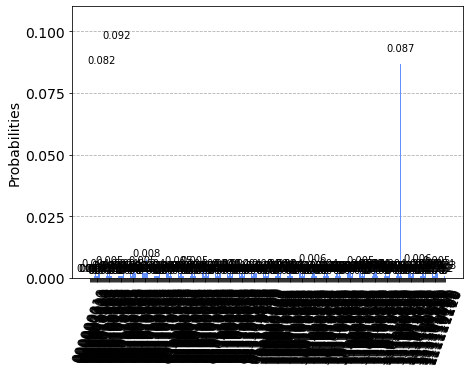

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram(result)

Jeśli Twoje rozwiązanie zostało zaakceptowane przez nasz weryfikator, stwórz i prześlij plik zgłoszeniowy **razem z tym notebookiem uzupełnionym o Twoje rozwiązanie wraz z komentarzami** (łącznie dwa pliki). Z Twoich komentarzy powinno być jasne jak działa Twoje rozwiązanie. Upewnij się, że w `twoje_id` poniżej podałeś/aś swój poprawny identyfikator!

Zgłoszeń można dokonać [tutaj](https://ibm.ent.box.com/f/4c9101c0616f4897920a02a67d077321).

In [31]:
twoje_id = "b6a0a5abfb"
create_submission(qcirc, result, twoje_id)

Wygenerowaliśmy plik do wysłania o nazwie: zgloszenie_konkursowe.json. Nie zapomnij wysłać notebooka z rozwiązaniem!
